In [3]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [11]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_smiles.yaml"
with open(os.path.join(repo_root, config_path)) as f:
    conf = yaml.safe_load(f)
    
transition_class, transition_conf, device, lang_path = (conf.get(k) for k in ("transition_class", "transition_conf", "device", "lang_path"))
if "model_dir" in transition_conf:
    transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
    lang_path = add_sep(transition_conf["model_dir"]) + lang_name
lang = Language.load(lang_path, device=device)
transition_class = class_from_package("transition", transition_class)
transition = transition_class(lang=lang, **transition_conf)

reward_class = class_from_package("reward", conf.get("reward_class"))
reward = reward_class(**conf.get("reward_conf", {}))
policy_class = class_from_package("policy", conf.get("policy_class"))
policy = policy_class(**conf.get("policy_conf", {}))

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Starting search...
1- time: 0.00, reward: -0.4900120295034673, node: Cc1ccccc1CNC(=O)Cn1cc([C@@H](C)O)cc1S(N)(=O)=O
2- time: 0.13, reward: 0.5967262542694441, node: O=C(NC[C@@H](C(F)(F)F)c1cccc(Br)c1)N1CCN(Cc2ccco2)CC1
3- time: 0.27, reward: 0.5759157321424443, node: N#C[C@H](C(=O)NCCCOc1ccc(Cl)cc1)c1cccc([N+](=O)[O-])c1
4- time: 1.68, reward: 0.3562788572345286, node: NC(=O)N1CCN(CC[C@H]2Cc3ccccc3C2)CC1
5- time: 1.77, reward: -0.19303573092967363, node: Nc1cc(Cl)c(-c2nccn2C(F)F)nc1O
6- time: 1.86, reward: -0.11279527095820001, node: NS(=O)(=O)S[C@H]1CCCN(c2ccccc2C(F)F)C1
7- time: 2.10, reward: 0.535235471817141, node: FCC(F)(F)CN(C(=O)Cn1cncc1-c1ccccc1)C1CCC1
8- time: 2.60, reward: 0.48590142749585213, node: N=C1CN(Cc2ccccc2Cl)C[C@@H]1/N=C/c1ccccc1
9- time: 2.78, reward: -0.5959735746507601, node: O[C@@H](CC[C@]1(N)c2ccc(F)cc21)C(=O)Nc1ccc(-c2nnno2)cc1
10- time: 4.23, reward: 0.6393418768881162, node: C[C@@H](c1cccs1)N(C)Cc1nc(-c2ccc(F)cc2)no1
11- time: 4.33, reward: -0.21984315257052

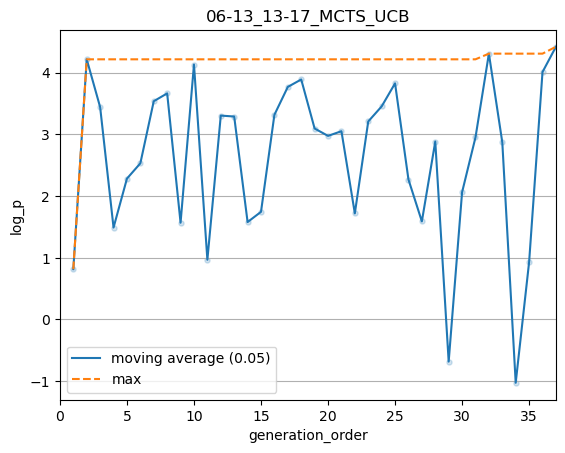

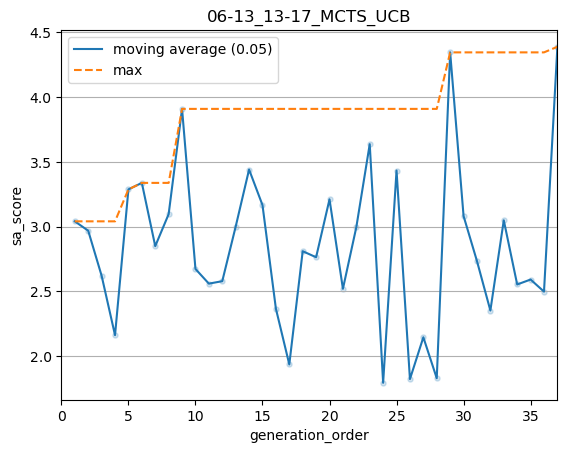

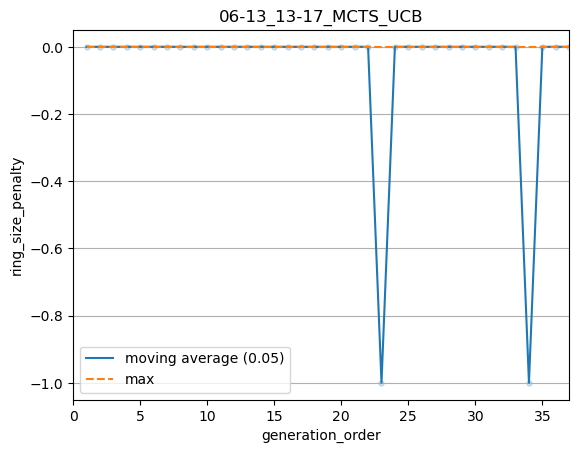

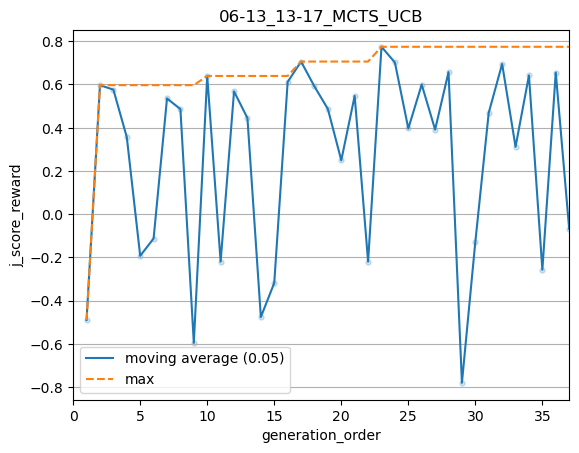

number of generated nodes: 37
valid rate: 0.21893491124260356
node_per_sec: 2.4532205920278023


In [12]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=conf.get("output_dir"), **conf.get("generator_conf"))
src = os.path.join(repo_root, config_path)
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
# cProfile.run("generator.generate(root=root, **generation_conf)"")
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [ ]:
#continue search
# generator.generate(max_generations=)
generator.plot(**conf.get("plot_conf"))
generator.analyze()

In [ ]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts
load_path = os.path.join(output_dir, "06-09_22-15_MCTS_PUCT/test.mcts")
generator = MCTS.load(load_path, transition)